*Disclaimer: this is not an offical Digital Earth Africa notebook*

<div class="alert alert-block alert-info">

<b>BLUE:</b> These represent information to the user of the notebook.
</div>

<div class="alert alert-block alert-danger">  
    
<b>RED:</b> These are warnings to the user of the notebook.
</div>

<div class="alert alert-block alert-warning">
 
<b>ORANGE:</b> These are questions and request for help.
</div>

# River and Urban Flooding

* **Products used:**
[strm 1 second elevation model](https://explorer.digitalearth.africa/products/srtm), 

<div class="alert alert-block alert-info">

<b>NOTE:</b> </div>

> This notebook is one of a companion piece and focuses on river and urban flooding. The other is titled [Coastal_Inundation_Tool](https://github.com/AdrianKriger/deafrica-sandbox-notebooks/blob/master/Real_world_examples/Coastal_Inundation_Tool.ipynb) and focuses on flooding as a result of a storm surge.

### Background

Flooding is an extremely complex and catastrophic phenomenon affecting millions of people with widespread Social, Economic and Environmental consequences. *([a recent paper highlights how flooding relates to the Sustainable Development Goals within Nigeria](https://www.tandfonline.com/doi/full/10.1080/20964129.2020.1791735))*. Flooding and its effects are particulary disruptive to low-income groups without a financial *safety-net* and who are more likely to live in flood-prone areas without suitable drainage. Informal settlements are of primary concern as water bourne disease, such as cholera, spread rapidly in areas without proper sanitation. Incidence of malaria has also been proven to increase following floods [(World Bank, 2015)](https://documents.worldbank.org/en/publication/documents-reports/documentdetail/418931467991989631/the-exposure-vulnerability-and-ability-to-respond-of-poor-households-to-recurrent-floods-in-mumbai,). Management of Floods are therefore crucial to poverty reduction and eradicating the burden of disease.

The first requirement to address flooding is to measure and monitor the phenomenon. Earth Observation datasets, such as those available through Digital Earth Africa, provide a cost-effective and accurate means of mapping its possible extent, impact and consequences; and serve to inform strategies that ensure resilience.

Similar too and as a complement to the [Coastal_Inundation_Tool]() this notebook is different from empirical methods and hydrodynamic models which are widely applied in flood inundation modelling. This notebook provides at a glance insights into riverine dynamics and urban flooding. To achieve this it serves to:
> **a) forecast River Flooding** through investigating the [srtm elevation dataset](https://explorer.digitalearth.africa/products/srtm)  held within DE Africa. `Elevation` data is retrieved from DE Africa and extracted to produce a water mask describing the possible flooding during extreme rainfall events through an inundation polygon. 

> **Attention:** This notebook goes further and validates an actual event. It focuses on the flooding along the **Congo River which occured on the 24~25 November 2019.** Specifically at **Kinshasa; Democratic Republic of Congo.** To test the effectiveness of the prediction [Sentinel 1 Synthetic Aperture Radar (SAR)](https://sentinel.esa.int/web/sentinel/sentinel-data-access) was sourced and processed to compare predicted with actual data.

> **b) address Urban Flooding**. Through validating the forecast *inundation* areas with an actual event; Urban Flooding  can also be investigated.

<!-- > `Detailed Explanation:`-->
<!--Data ... time.-->

### Description
This notebook will extract elevation profiles related to inundation senarios. And overlay flood masks to visualize the potential impact of rivine flooding.

**a) River Flooding**  
1.  Load in the srtm
2.  Extract Area of Interest
3.  Generate possible riverine flooding senarios
4.  Plot the results
5.  Overlay and visualize the result.
6.  Export inundation polygons (masks).

**b) Urban Flooding** 

7. Validate riverine flooding predictions and address Urban Flooding. 

<!-- 6.  Validate  -->
<!-- 7.   -->
***

## Getting started
**To execute this analysis**, run all the cells in the notebook, starting with the **Load packages** cell.

**After finishing the notebook**, return to the **Analysis parameters** cell, modify some values *(e.g. choose a different area of interest)* and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

***

<div class="alert alert-block alert-info"><b>
     
a) RIVER FLOODING</b></div>

>Riverine (Fluvial) Flooding is a complely natural and frequent reality for many rivers. It occurs when a river overspills its banks *(or when the channel can no longer contain the flow of water)*. 

>This portion of the notebook serves to understand the extent of River Flooding as a natural recuring process through the form of inundation polygons (masks).

### Load packages

In [7]:
%matplotlib inline

import sys
import datacube
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

from osgeo import gdal

from scipy import ndimage

sys.path.append('../Scripts')
from deafrica_spatialtools import xr_vectorize
from deafrica_plotting import display_map, rgb
from datacube.utils.cog import write_cog
from deafrica_datahandling import load_ard, wofs_fuser
#from deafrica_dask import create_local_dask_cluster

#This will speed up loading data
#datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app='River_and_Urban_Flooding')

### Analysis parameters 

The following cell sets important parameters for the analysis:

- lat: The central longitude to analyse (e.g. -4.31).
- lon: The central latitude to analyse (e.g. 15.25).
- buffer: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as 0.1 or lower.

**If running the notebook for the first time**, keep the default settings below. This will demonstrate how the analysis works and provide meaningful results. The example generates inundation polygons (masks) for an area near Kinshasa, Democratic Republic of the Congo.

In [3]:
# Define the central point of the area of interest
lat, lon = -4.31, 15.25

# buffer will define the upper and lower boundary from the central point
buffer = 0.1   

# Combine central lat, lon with buffer to get area of interest
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

### View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point

In [4]:
display_map(x=(lon - buffer, lon + buffer), y=(lat + buffer, lat - buffer))

## Load elevation data

To evaluate River Flooding, we first need to obtain an elevation dataset. DE Africa's datacube contains a Digital Elevation Model (DEM) from the [Shuttle Radar Topography Mission (SRTM)](https://lpdaac.usgs.gov/documents/13/SRTM_Quick_Guide.pdf). We can load in elevation data directly from the datacube using `dc.load`.

The Shuttle Radar Topography Mission NASA JPL Version 3.0 *(“SRTM Plus”)* is void filled with non-commercial ASTER GDEM2, GMTED2010, and NED, to produce a 1 arc-second (~30m) product.

<div class="alert alert-block alert-danger">
    
<b>WARNING:</b> This elevation dataset is not hydrologically correct and is not meant for hydraulic analysis. To ensure quality analysis standard practice recommends processing before any investigation. We only perform basic 'smoothing'. Our result thus serves as a guide to inform further study.</div>

In [5]:
# Create a dem reusable query
dem_query = {
    'x': (lon_range),
    'y': (lat_range),
    'output_crs': 'EPSG:3342',    # utm33s
    'resolution': (-30, 30)
}

#load elevation
elevation_array = dc.load(product ='srtm', **dem_query)
elevation_array

<xarray.Dataset>
Dimensions:      (time: 1, x: 741, y: 738)
Coordinates:
  * time         (time) datetime64[ns] 2019-09-09
  * y            (y) float64 9.535e+06 9.535e+06 ... 9.513e+06 9.513e+06
  * x            (x) float64 5.168e+05 5.168e+05 ... 5.389e+05 5.39e+05
    spatial_ref  int32 3342
Data variables:
    elevation    (time, y, x) int16 367 364 365 365 365 ... 329 332 335 338 336
Attributes:
    crs:           EPSG:3342
    grid_mapping:  spatial_ref

Once the load is complete, the last `elevation_array` parameter printed it. The returned `Dataset` has a single entry in the `time` dimension. To make the data easier to work with, we convert it to a `dataArray`.

In [80]:
#convert to an dataArray (rather an Dataset) and select single time-slice
dem30 = elevation_array[['elevation']].isel(time=0).to_array()

In [151]:
# median_filter with 7x7 kernel size
demMF = ndimage.median_filter(dem30.squeeze(), size=7, mode='mirror')

nu_passes = 3
sigma = 2
truncate = 1.25

dem = demMF
#or without the median ~
#dem = dem30.squeeze()

for i in range(nu_passes):
    dem = ndimage.gaussian_filter(dem, sigma=sigma, mode='mirror', truncate=truncate)
    
#create a DataArray object
dem = xr.DataArray(data = dem.squeeze(),
                   coords = {'y': dem30.y, 
                             'x': dem30.x},
                             #'spatial_ref': 2736},
                   #attrs = {'crs': 'EPSG:2736'},
                   dims = ["y", "x"])

### Plot the loaded data

We can plot the elevation data for the region using a custom colour map:

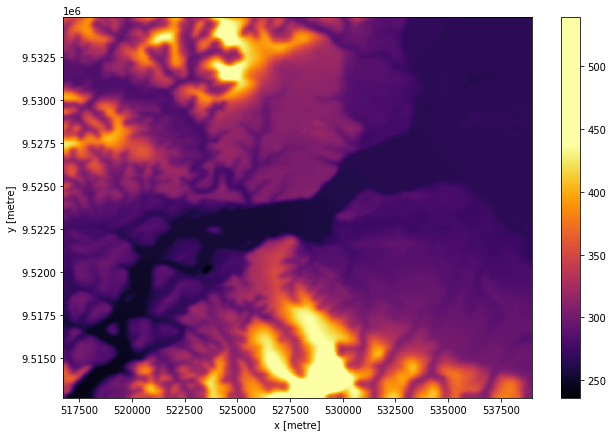

In [152]:
# Create a custom colourmap for the DEM
colors_terrain = plt.cm.inferno(np.linspace(0.0, 1.5, 25))
cmap_terrain = mpl.colors.LinearSegmentedColormap.from_list('inferno', colors_terrain)

# Plot a subset of the elevation data
dem.plot(size=7, cmap=cmap_terrain)
plt.show()

### Histogram

An extremely effect method of exploring the distribution of elevation values is a histogram.

We extend the basic `matplotlib` `.hist` function and apply our previously generated `colormap`. This way the histogram *(the distribution)* matches the plot above.

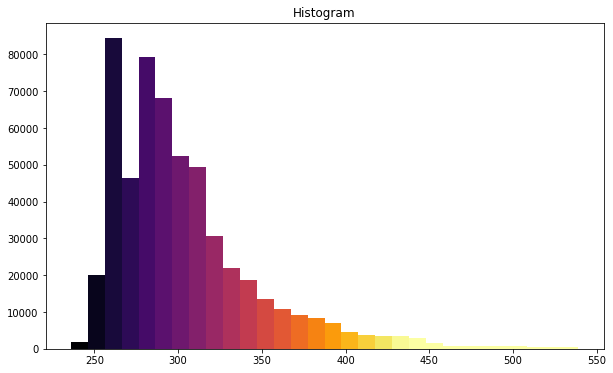

In [153]:
# Plot instance
f, ax = plt.subplots(figsize=(10, 6))

# histogram.
n, bins, patches = dem.squeeze().plot.hist(ax=ax,
                                           color="purple",
                                           bins=30)                 # feel free to change these 
bin_centers = 0.8 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cmap_terrain(c))

plt.show()

The histogram above represents the distibution of elevation values in our data. It provides a shapshot of our area of interest and is usefull because: 

   * We can easily identify outliers;  
   * Quickly determine the `min` and `max` values;  
   * Explore the general distribution values of the data and draw conclusions *(is the area hilly? or flat? is the area low-lying or high-lying?)*.

## Extract multiple inundation senarios

Many methods and hydrodynamic models exist to simulate inundation. These methods are essential for engineering complex flood control systems. The method employed with this notebook is the least sophisticated built upon the popular [Flood Fill](https://en.wikipedia.org/wiki/Flood_fill) image processing technique. Flood Fill determines the area connected to a given node in a multiple dimension array and is used in the *bucket* tool of paint programs to fill connected, similarly-colored areas with a different color, and in games such as **Go** and **Minesweeper** for determining which pieces are cleared. This tool thus assumes that flood water will flow to areas of the same elevation. 

> **NOTE:** Flood Fill is a first-order model and starts with a single point *(generally refered to as the pour point)* and floods an area with the maximum volume of water the basin can hold at a particular flood stage. **Typically this is a worst case senario.** Our model needs an elevation to start with and takes some exploratory analysis ~ through viewing the area `(cell 4)`, and investigating the elevation `(cell 7 and 9)` we can see the area between Brazzaville, in the north, and Kinshasa, to the south, is trending away from black towards a lighter purple: between `250` and `300` meters. we choose `265`.

Input Start elevation

In [154]:
start_elevation = 265

We extract possible flooding senarios at every 1 meter for 6 meters. `python` counts from zero. To extract elevations from 0 to six meters we set a range of seven.

In [155]:
flood_range = 7

Then place each elevation in a dictionary.

In [156]:
elevation_range = []
for i in range(int(flood_range)):
    #print(i)
    elevation_range.append(i + int(start_elevation))
    #print(mask)

### Flood Fill 

We define a [Flood Fill](https://en.wikipedia.org/wiki/Flood_fill) function. The challenge with our first-order algorithm is the results vary and depend on the *pour point*. **Generally these points are known; such as a stream gauge or a breach in a Dam.**

In [157]:
def floodFill(c, r, mask):
    """
    Crawls a mask array containing only 1 and 0 values from the starting point (c=column, r=row - a.k.a. x, y) and returns
    an array with all 1 values connected to the starting cell. This algorithm performs a 4-way check non-recursively.
    """
    # cells already filled
    filled = set()
    # cells to fill
    fill = set()
    fill.add((c, r))
    
    width = mask.shape[1]-1
    height = mask.shape[0]-1
    
    # Our output inundation array
    flood = np.zeros_like(mask, dtype=np.int8)
    
    # Loop through and modify the cells which need to be checked.
    while fill:
        # Grab a cell
        x, y = fill.pop()
        if y == height or x == width or x < 0 or y < 0:
            # Don't fill
            continue
            
        if mask[y][x] == 1:
            # Do fill
            flood[y][x] = 1
            filled.add((x, y))
            
            # Check neighbors for 1 values
            west = (x-1, y)
            east = (x+1, y)
            north = (x, y-1)
            south = (x, y+1)
            if west not in filled:
                fill.add(west)
            if east not in filled:
                fill.add(east)
            if north not in filled:
                fill.add(north)
            if south not in filled:
                fill.add(south)
                
    return flood

### Execute the function and create masks.

In [123]:
# The seed of the flood fill algorithm is very important. 
# We presume flood always starts from the lowest point.
sy, sx = np.unravel_index(dem.values.squeeze().argmin(), dem.squeeze().shape)

da_flood = {}
img = dem.values.squeeze()

for i in range(int(flood_range)):
    a = np.where(img < elevation_range[i], 1, 0)       # we set this from our elevation
    #print("Image masked")
    
    #print("Beginning flood fill")
    fld = floodFill(sx, sy, a)
    #print("Finished Flood fill")
    
    #print('restore to dem')
    where_0 = np.where(fld == 0)
    where_1 = np.where(fld == 1)
    fld[where_0] = 0
    fld[where_1] = 1
    key = int(elevation_range[i])
    
                  # we want a mask with True and False values so: .astype(bool)
    da_flood[key] = (fld).astype(bool) # dem*fld    

In [158]:
# The seed of the flood fill algorithm is very important. 
# We presume flood always starts from the lowest point.
sy, sx = np.unravel_index(dem.values.squeeze().argmin(), dem.squeeze().shape)

da_flood = {}
img = dem.values.squeeze()

for i in range(int(flood_range)):
    a = np.where(img < elevation_range[i], 1, 0)       # we set this from our elevation
    #print("Image masked")
    
    #print("Beginning flood fill")
    fld = floodFill(sx, sy, a)
    #print("Finished Flood fill")
    
    #print('restore to dem')
    where_0 = np.where(fld == 0)
    where_1 = np.where(fld == 1)
    fld[where_0] = 0
    fld[where_1] = 1
    key = int(elevation_range[i])
    
    dm = xr.DataArray(data = (fld).astype(bool),
                       coords = {'y': dem30.y, 
                                 'x': dem30.x},
                             #'spatial_ref': 2736},
                       #attrs = {'crs': 'EPSG:2736'},
                       dims = ["y", "x"])
    
                  # we want a mask with True and False values so: .astype(bool)
    da_flood[key] = dm #(fld).astype(bool) # dem*fld  

### Plot each possible water level

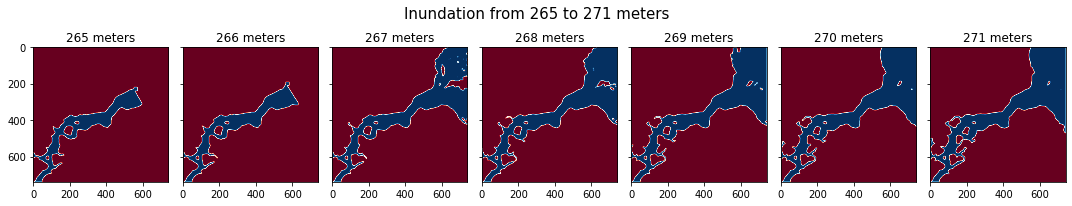

In [159]:
_, axs = plt.subplots(1, len(da_flood), figsize=(15, 15), sharey='row')
axs = axs.flatten()
for img, ax in zip(da_flood, axs):
    ax.imshow(da_flood[img].squeeze(), cmap='RdBu')
    ax.set_title(str(img) + ' meters')
    
plt.suptitle('Inundation from ' +str(start_elevation)+ ' to ' +str(int(flood_range - 1)+int(start_elevation))+ ' meters', size = 15, y = 0.60)

plt.tight_layout()
plt.show()

We immediately see how the inundation *(flood)* will spread once the maximum volume the basin can hold at `265` meters is exeeded. 

## Refine prediction

We can improve our prediction through excluding areas that are normally classified as water. To do so we explore the [Water Observation from Space (WOfS) annual summary](https://explorer.digitalearth.africa/products/ga_ls8c_wofs_2_annual_summary/extents) product within Digital Earth Africa. This product records how often a pixel was classified as water in a given year. Through removing these water covered areas our prediction allows us to concentrate on possible flooded areas only.

## Load WOfS annual summary

In [160]:
# Create a query
wofs_query = {
    'x': (lon_range),
    'y': (lat_range),
    'output_crs': 'EPSG:3342',    # utm33s
    'time': ('2018-01-01', '2018-12-30'),
    'resolution': (-30, 30)
}

# Load the data from the datacube
wofls = dc.load(product="ga_ls8c_wofs_2_annual_summary", group_by="solar_day",
                            fuse_func=wofs_fuser, **wofs_query)

In [30]:
wofls

<xarray.Dataset>
Dimensions:      (time: 1, x: 741, y: 738)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999500
  * y            (y) float64 9.535e+06 9.535e+06 ... 9.513e+06 9.513e+06
  * x            (x) float64 5.168e+05 5.168e+05 ... 5.389e+05 5.39e+05
    spatial_ref  int32 3342
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 6 6 6 6 5 5 5 5 5 5 ... 6 6 6 6 5 5 4 5 5 5
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           EPSG:3342
    grid_mapping:  spatial_ref

In [41]:
mask_with90 = wofls.squeeze().frequency >= 0.9
mask_with90.values

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

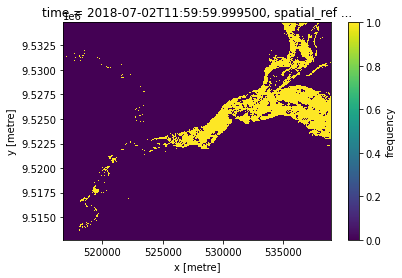

In [42]:
#plot
mask_with90.plot()

## New Inundation Senario

With our possible flooding levels and WOfS we simply create a water mask, and new refined predictions.

In [161]:
new_mask = {}

for i in da_flood:
    new_mask[i] = da_flood[i].where(wofls.frequency <= 0.9) #wofls.squeeze().frequency >= 0.9)

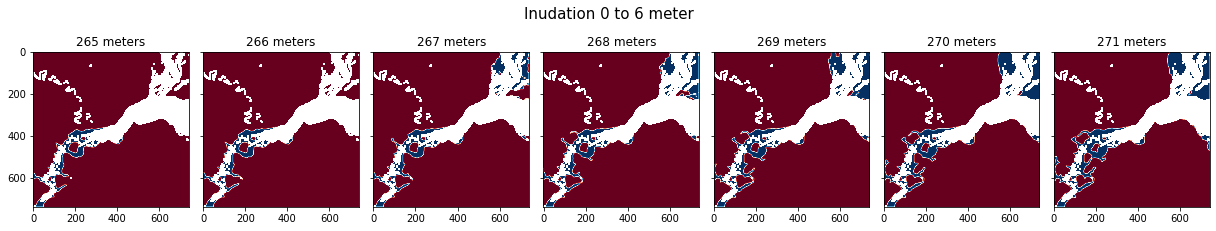

In [162]:
_, axs = plt.subplots(1, len(new_mask), figsize=(17, 17), sharey='row')
axs = axs.flatten()
for img, ax in zip(new_mask, axs):
    cb = ax.imshow(new_mask[img].squeeze(), cmap='RdBu')
    ax.set_title(str(img) + ' meters')

#plt.colorbar(cb)                                                      #perhaps a colorbar would be informative - add divider?
plt.suptitle('Inudation 0 to 6 meter', size = 15, y = 0.6)
plt.tight_layout()
plt.show()

### Vectorize each elevation mask to a geodataframe

In the cell below, we use the argument `mask=da_flood.values==1` to indicate we only want to convert the values in the xarray object that are equal to 1. We also add a `vectorize_gdf['z_value'] = i` parameter to add an elevation attribute to each polygon.

> **Note:** Both `xr_rasterize` and `xr_vectorize` will attempt to automatically obtain the crs and transform from the input data, but if the data does not contain this information, you will need to manually provide this. In the cell below, we will get the crs and transform from the original dataset.

In [225]:
gdf = gpd.GeoDataFrame()

for i in new_mask:
        vectorize_gdf = xr_vectorize(new_mask[i].squeeze(),
                                     crs=wofls.crs,
                                     transform=wofls.geobox.transform,
                                     mask=new_mask[i].squeeze().values==1)#da_flood[i]==1)
        vectorize_gdf['z_value'] = i
        gdf = gdf.append(vectorize_gdf, ignore_index=True)

This returns a `geopandas.GeoDataFrame` containing each flooding senario with the elevation given in a field named `z_value`. 

> We can query the `.unique` elevation (`z_values`) values

In [226]:
gdf.z_value.unique()

array([265, 266, 267, 268, 269, 270, 271])

> And we can query the `.head`  and `.tail` of the `GeoDataFrame`

In [227]:
gdf.tail(5)
#gdf.head(5)    # uncomment to view head ~ remember to # (hash) the top line

,attribute,geometry,z_value
3945,1.0,"POLYGON ((519450.000 9515640.000, 519450.000 9...",271
3946,1.0,"POLYGON ((519540.000 9515130.000, 519540.000 9...",271
3947,1.0,"POLYGON ((518760.000 9514170.000, 518760.000 9...",271
3948,1.0,"POLYGON ((518160.000 9514050.000, 518160.000 9...",271
3949,1.0,"POLYGON ((527310.000 9524100.000, 527310.000 9...",271


### Plot a selected water level over the DEM

Select an elevation between 267 and 271 meters

In [236]:
test = 269

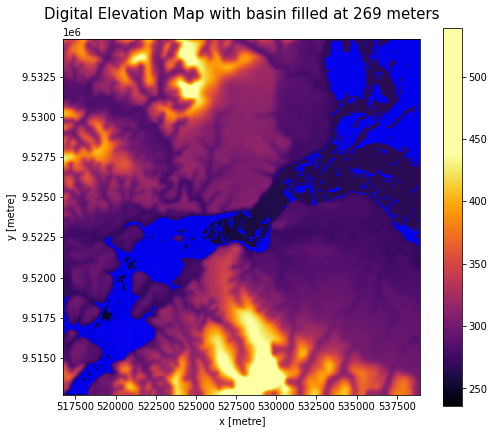

In [241]:
assert test >= gdf.z_value.unique()[0] and test <= gdf.z_value.unique()[-1], \
'Values must be between '+str(gdf.z_value.unique()[0])+' and '+str(gdf.z_value.unique()[-1])
    
# Plot a subset of the elevation data
fig, ax = plt.subplots(figsize=(8,6))
#fig.patch.set_alpha(0)

dem.plot(cmap=cmap_terrain, zorder=1)
gdf_plot = gdf[gdf['z_value'] == test]
gdf_plot.plot(ax=ax, zorder=2, color='blue', linewidth=0.5, alpha=0.9)
ax.set_title('Digital Elevation Map with basin filled at ' +str(test)+ ' meters', pad=20, fontsize=15)
plt.subplots_adjust(top=1)
plt.show()

### Export River Flood senarios to file

The GeoDataFrame natively exports as a shapefile for use in other applications.

> Exporting to GeoJSON is supported through adding the `driver=` parameter ~ `gdf.to_file("CoastalInundation.geojson", driver='GeoJSON')`

In [ ]:
gdf.to_file("../Supplementary_data/WorkingFolder/RiverFlooding.shp")

## 3D Surface Visualization

We can create a dynamic visualization showing possible flooding over a 3D surface.

> **NOTE**: `mpl_toolkits.mplot3d` `Axes3D` the module used to represent the DEM as a 3D surface is computationally expensive. Even with the region `buffer` set to 0.1 degrees rendering the plot will some time.

/env/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Z contains NaN values. This may result in rendering artifacts.


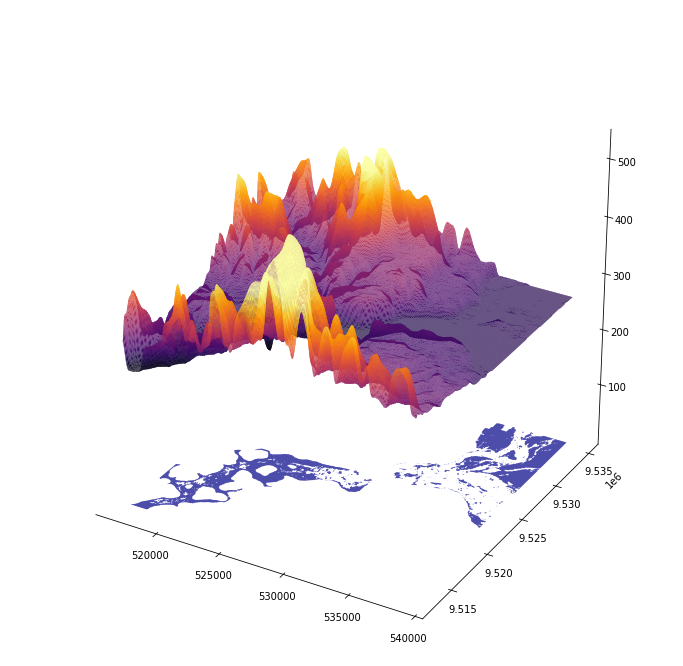

In [242]:
# set up a figure 
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')

#transform the image
xres = elevation_array.geobox.transform[0]
yres = elevation_array.geobox.transform[4]
X = np.arange(dem30.geobox.transform[2], dem30.geobox.transform[2] + dem30.shape[1:][1]*xres, xres)
Y = np.arange(dem30.geobox.transform[5], dem30.geobox.transform[5] + dem30.shape[1:][0]*yres, yres)
X, Y = np.meshgrid(X, Y)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# plot a 3D surface --- oriented North West from the bottom right corner
surf = ax.plot_surface(X,Y,dem.squeeze(), rstride=2, cstride=2, cmap=cmap_terrain, linewidth=0, antialiased=True, zorder=2)
#w = ax.plot_surface(X,Y,w, rstride=2, cstride=2, color='b', linewidth=0, antialiased=True, zorder=1)

water_m = new_mask[test].squeeze().copy()
wm = water_m.fillna(test)
idx = np.where(water_m.values == 1.)
wm[idx[0][0]] = test
w = ax.plot_surface(X,Y, wm.where(wm == 1), 
                     rstride=2, cstride=2, color='b', linewidth=0, antialiased=True, zorder=2)

ax.view_init(30, 300)

plt.show()

<div class="alert alert-block alert-warning"><b>ATTENTION:</b></div>
    
> How to "hard-code" and visualize only a fraction of the total analysis area? (so that the analysis area can increase in size but exploratory visualization is less computationally expensive).
    
> Overlaying the DEM with the flood level is also proving challenging. The water is not at the right height.

## Validation

In order to test the effectiveness of our tool we can compare an actual event with our prediction.

> **On 24~25 November 2019** heavy rainfall caused several rivers to break their banks in and around **Kinshasha, Democratic Republic of Congo.** The event is not an isolated incident as flooding is a frequent occurence. ([Floodlist, 2019](http://floodlist.com/africa/dr-congo-floods-andslides-kinshasa-november-2019))

One of the major challenges with optical Earth Observation datasets over Central Africa is the nearly constant cloud cover. Optical datasets, such as [Sentinel 2](https://explorer.digitalearth.africa/products/s2_l2a) available within DE Africa, cannot penetrate the cloud-cover.

We can execute a query and check.

In [243]:
# Define the start and end dates that define the search
start_year = '2019-11-22'
end_year = '2019-12-02'

#Create a query object
sen_query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'resolution': (-10, 10),
    'output_crs':'EPSG:3342',
    'group_by': 'solar_day',
    'time': (start_year, end_year)
    #'dask_chunks':{'time':1,'x':1000,'y':1000}
}

In [244]:
ds_sen2 = load_ard(dc=dc,
                      products=['s2_l2a'],
                      measurements=['red', 'green', 'blue', 'nir'],
                      #min_gooddata = 0.10,
                      **sen_query)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 4 time steps


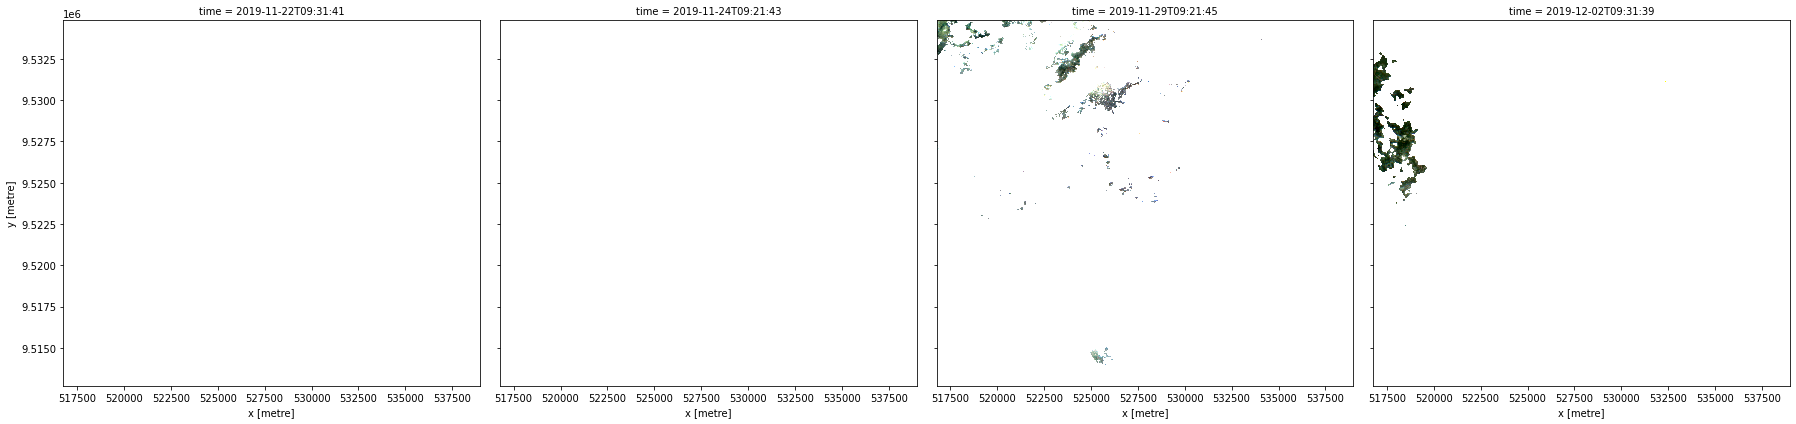

In [96]:
rgb(ds_sen2, col='time', col_wrap = 5)

Cloud cover prevents a certain evaluation after reported flooding (24~25 November).

### Sentinel-1

> **Radar observations are largely unaffected by cloud cover, so can take reliable measurements of areas in any weather.** Radar data is readily available from the ESA/EC Copernicus program's Sentinel-1 satellites. The two satellites provide all-weather observations, with a revisit time of 6 days. By developing a process to classify the observed pixels as either water or land, it is possible to identify the water from radar data. For more information, see the [Detecting water with radar](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Real_world_examples/Radar_water_detection.ipynb) and [Sentinel-1](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/03b7b41d5f6526ff3f33618f7a0b48c0d10a155f/Datasets/Sentinel_1.ipynb)  notebooks.

> Unfortunately DE Africa does not have the data we need. Fortunately Google Earth Engine does.

In [ ]:
from shapely.geometry import Polygon
from shapely.geometry import box

## Google Earth Engine

[Google Earth Engine (GEE)](https://developers.google.com/earth-engine) serves as the perfect complement to DE Africa. It is a planetary scale platform for Earth Science data and analysis with a peta-byte catalog of satellite imagery and geospatial dataset. Access to Earth Engine services is through one of three Application Protocol Interface's (API's). Client libraries for [JavaScipt (in the Code Editor)](https://developers.google.com/earth-engine/guides/playground) and [Python (in Colab)](https://developers.google.com/earth-engine/guides/python_install) or directly using REST API.

### GEE Code Editor

The script to execute the water identification from SAR imagery is available [here](https://code.earthengine.google.com/?scriptPath=users%2Farkriger%2Fsen1_water%3AKinshasa20191125_un-spider). A GEE account might be necessary.

<div class="alert alert-block alert-warning">
    
<b>Attention:</b> IT WILL BE HELPFUL TO TEST THE EFFECTIVENESS OF THE LINK AND SCRIPT. IS THERE ANOTHER / BETTER METHOD TO SHARE IT?</div>

<div class="alert alert-block alert-info"><b>NOTE:</b></div>

> - The `geometry` must be uncommented in line `22` for the script to execute successfully. Alternatively an Area of Interest *(a shapefile ~ see below)* can be imported as an `Assest`.
> - Flood extent is calculated through change detection. An after-flood mosaic is divided by a before-flood mosaic, resulting in a raster layer showing the degree of change per pixel. The predefined `threshold` of `1.1` is applied assigning `1` to all values greater than `1.1` and `0` to all values less than `1.1`. The flood extent is further refined through eliminating all areas covered by water for more than 10 months per year and removing areas over 5% slope. For more information; please see [UN-Spider Knowledge Portal](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-google-earth-engine-flood-mapping/step-by-step).
> - When the script is `Run` export of the flood extent as a raster and vector is catered for and will highlight as a `Task`.

### Define the extents of the area of interest and export to .shp

To make our work less error prone we use the extents of our area of interest to define a boundary box which we convert to a shapefile. This polygon is then imported to Google Earth Engine to limit our search area and serve as a basis to then extract the data (water coverage) we need.

In [26]:
minx = elevation_array.geobox.transform[2]
maxy = elevation_array.geobox.transform[5]
maxx = minx + elevation_array.geobox.transform[0] * dem.shape[1:][0]
miny = maxy + elevation_array.geobox.transform[4] * dem.shape[1:][1]

coordinates = [minx, miny, maxx, maxy]
print(coordinates)

[516750.0, 9512610.0, 538890.0, 9534840.0]


In [ ]:
bbox = gpd.GeoDataFrame({"id":1,"geometry":[box(*coordinates)]})
bbox = bbox.set_crs("EPSG:3342")

In [ ]:
bbox.head()

### Export

In [ ]:
bbox.to_file("../Supplementary_data/WorkingFolder/bbox.shp")

## Import the SAR water classification

In [245]:
dataset = gdal.Open('../Supplementary_data/WorkingFolder/kinshasa_un-spider.tif')#, gdal.GA_ReadOnly) 

# Note GetRasterBand() takes band no. starting from 1 not 0
arr = dataset.ReadAsArray()

#plt.imshow(arr)

<div class="alert alert-block alert-info"><b>

b) URBAN FLOODING</b></div>

> In the 21st century Urban (Pluvial) Flooding has emerged as distinct and seperate from Coastal Inundation and River Flooding. Urban Flooding is the accumulation of flood water that results when artificial drainage systems are unable to absorb and manage the flow of water. It is caused by over burdened drainage systems, uncontrolled and unregulated construction with no regard for the natural topography and hydro-geomorphology.
    
>Urban Flooding is a global phenomenon increasing in frequency fueled by growing populations transforming the natural environment and severe weather events caused by anthropogenic climate change.
   
>This portion of the notebook serves to understand the extent of Urban Flooding following a *heavy* rainfall event.

## Compare the actual Riverine Flooding with the predictions

In [246]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

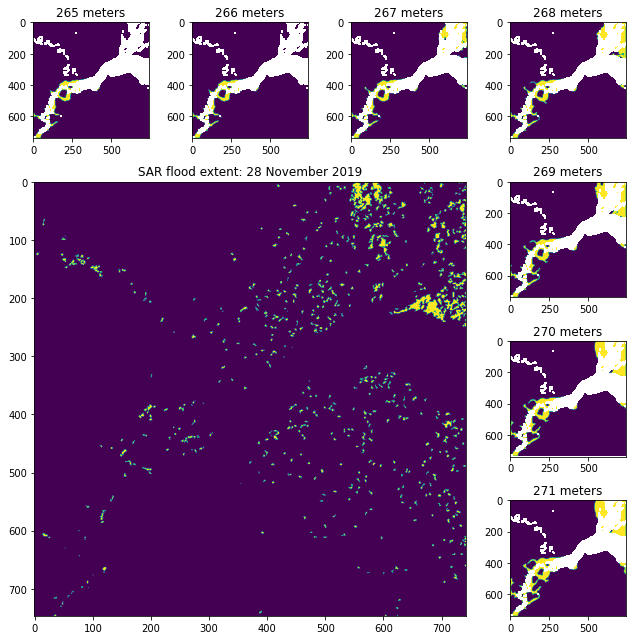

In [249]:

fig = plt.figure(figsize=(9, 9), constrained_layout=False)
a1 = plt.subplot2grid((4,4),(0,0))
a2 = plt.subplot2grid((4,4),(0,1))
a3 = plt.subplot2grid((4,4),(0,2))
a4 = plt.subplot2grid((4,4),(0,3))

a5 = plt.subplot2grid((4,4),(1,0), rowspan = 3, colspan = 3)

a6 = plt.subplot2grid((4,4),(1,3))
a7 = plt.subplot2grid((4,4),(2,3))
a8= plt.subplot2grid((4,4),(3,3))

a1.imshow(new_mask[265].squeeze())
a1.set_title('265 meters')
a2.imshow(new_mask[266].squeeze())
a2.set_title('266 meters')
a3.imshow(new_mask[267].squeeze())
a3.set_title('267 meters')
a4.imshow(new_mask[268].squeeze())
a4.set_title('268 meters')
a5.imshow(arr) #a1.set_title('exp')
a5.set_title('SAR flood extent: 28 November 2019')
a6.imshow(new_mask[269].squeeze())
a6.set_title('269 meters')
a7.imshow(new_mask[270].squeeze())
a7.set_title('270 meters')
a8.imshow(new_mask[271].squeeze())
a8.set_title('271 meters')

#plt.axes.xaxis.set_ticks([])
#plt.axes.yaxis.set_ticks([])
#plt.tick_labels('off')
plt.tight_layout()
plt.show()

## Address Urban Flooding

Explore flooding in the urban environment.

<div class="alert alert-block alert-warning">  
    
<b>Attention:</b> Is this overreaching? Is this result realistic? Is this result the *start-point* of further on-site investigation?
</div>

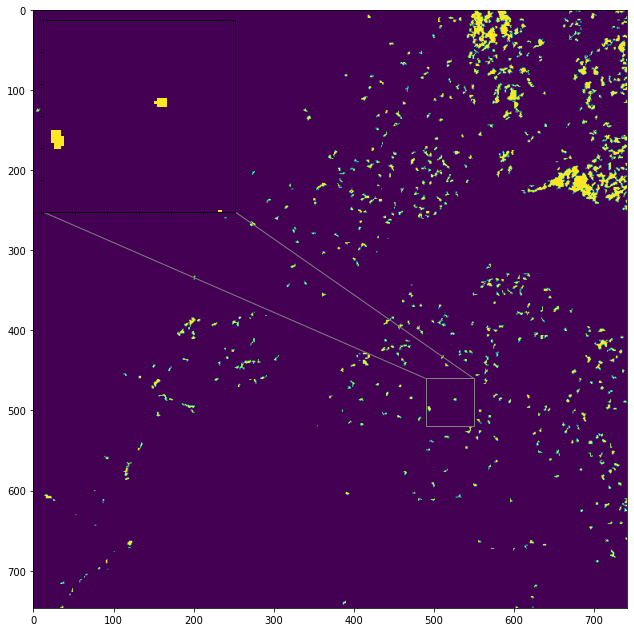

In [248]:
fig, ax = plt.subplots(figsize=[11, 11])

ax.imshow(arr, origin="upper")                                #interpolation="nearest" ~ can be an additional parameter
          
# inset axes....
#axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
axins = zoomed_inset_axes(ax, 4, 'upper left', borderpad=1)  # zoom = 4
axins.imshow(arr, origin="upper")                            #interpolation="nearest" ~ can be an additional parameter
             
# sub region of the original image
axins.set_xlim(490, 550)

#axins.set_ylim(450, 510)
axins.set_ylim(520, 460)                                    # matplotlib has an inherent challenge with "flipping" zoomed insets 

axins.set_xticklabels('')
axins.set_yticklabels('')

plt.xticks(visible=True)  # Not present ticks
plt.yticks(visible=True)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")

ax.indicate_inset_zoom(axins)

plt.show()

## Interactive Water Extent Visualization

<div class="alert alert-block alert-warning">

<b>ATTENTION:</b> Is an interactive visualization to much? ~ It would make zooming and panning within the notebook possible.
</div>

## Drawing conclusions

Here are some questions to think about:
* What can you conclude about the actual level of Inundation? 
* Which sections of the flood plain are likely to be most affected?
* Is the riverine flooding prediction realistic? How can the prediction be improved?
* With regard to Urban Flooding; what other information might you need to draw additional conclusions about potential problem areas?

## Next steps
When you are done, return to the "Analysis parameters" cell, modify some values (e.g. `lat`/`lon`) and rerun the analysis.

Consider increasing the `buffer` and exploring a larger area without the *computationally expensive* 3D Visualization. 